In [1]:
#
#
#
#

from urllib import request
from time   import sleep
from bs4    import BeautifulSoup

import requests
import pandas as pd
import re

# Links for IOP search

IOP_S  = "https://iopscience.iop.org/nsearch?terms="
IOP_E  = "&nextPage=2&previousPage=-1&currentPage="
IOP_P  = "&searchDatePeriod=anytime&orderBy=relevance&pageLength=50"

# Links for NATURE search

NANO_S = 'https://nano.nature.com/search?term=freeText%3A'
NANO_E = '&sort-by=relevance&page-number='
NANO_P = '&workflow=article'


"""==============================================================================================================================="""

# -format- returns a string that can be readed as a query to IOP or NANO

def format(query):
    pre_form = query.split(" ")
    return "+".join(pre_form)


"""==============================================================================================================================="""

# Some pages may have problems if requested with -urllib- or -requests-, SwitchKitchen is implemented to
# switch the way we obtain a BeautifulSoup object


def SwitchKitchen(uri, kitchen = "requests", parse = "lxml"):

    # Request with --requests.get(url)--

    if   kitchen == "requests":
         response = requests.get(uri)
         soup     = BeautifulSoup(response.text, parse)

    elif kitchen == "urllib":

    # Request with --request.urlopen(url)--

         response = request.urlopen(uri)
         soup     = BeautifulSoup(response, parse)
    else:
        raise Exception("Problema en la elección del método mara obtener la respuesta del servidor.")
    return soup;

"""==============================================================================================================================="""

# /Souparticles : Returns a list of BeautifulSoup objects that contain articles

# /material     : Is a str. containing the search term
# /page         : The page in which we are searching
# /max_try      : The maximum tries before givin up, commonly this is a result of a 400 status response from the server
# /slpy         : Is the time between requests, recommended to prevent overloading requested server


def souparticlesIOP(query, page, max_int = 5, slpy = 3):
    # At the beginning our IOP Soup is a None object
    soupIOP = None
    ints  = 0

    while ints<max_int:    
    # We try to catch some content from the server

        try:
            uri      = IOP_S+ format(query) + IOP_E + str(page) + IOP_P
            # If we catch a 200 response we can make a Beautifoul Soup (BS), parsing with lxml
            soupIOP  = SwitchKitchen(uri,kitchen = "urllib")
            break
        except:
            # If we catch an error, we can retry
            print("Reintentando pag: " + str(page))
            sleep(slpy)
            pass
        finally:
            ints +=1
    
    # For soupIOP == None this process needs to be repeated
    if(soupIOP==None):
        print( "Por favor reinicie la busqueda para pag: " + str(page))
        return None;
    else:
        # Returning the articles in a BS object
        print("Añadida pag: " + str(page))
        return soupIOP.find_all('div', {"class" : "art-list-item-body"})

"""==============================================================================================================================="""

def souparticlesNANO(query, page, max_int = 5, slpy = 3):
    nanosoup = None
    ints=0
    while ints<max_int:
        try:
            uri      = NANO_S+'"'+format(query)+'"'+NANO_E+str(page)+NANO_P
            nanosoup = SwitchKitchen(uri, kitchen = "requests")
            break
        except:
            print("Reintentando pag: " + str(page))
            sleep(slpy)
            pass
        finally:
            ints +=1
    if(nanosoup==None):
        print( "Por favor reinicie la busqueda para pag: " + str(page))
        return None;
    else:
        print("Añadida pag: " + str(page))
        return nanosoup.find_all('li', {"class" : "Results_listItem" })

"""==============================================================================================================================="""

# -Pages- returns a list of pages, each element contains the articles within that page

def PagesIOP(query):
    raw_pages   = []
    init_uri  = IOP_S+ format(query) + IOP_E + str(1) + IOP_P
    init_soup = SwitchKitchen(init_uri,kitchen = "urllib")
    end_pages = init_soup.findChild("p",{"class":"pgs small"}).get_text().split(" ")[2]
    for i in range(1, int(end_pages)+1):
        raw_pages.append(souparticlesIOP(query, i))
    return raw_pages;

"""==============================================================================================================================="""

def PagesNANO(query, cut = 12):
    raw_pages = []
    init_uri  = NANO_S+'"'+format(query)+'"'+NANO_E+str(1)+NANO_P
    init_soup = SwitchKitchen(init_uri,kitchen = "requests")
    end_pages = init_soup.findChild("span",{"class":"Pagination_numOfPages"})
    num_of_pgs= int(end_pages.get_text())
    if num_of_pgs<12:
        for i in range(1,num_of_pgs+1):
            raw_pages.append(souparticlesNANO(query, i))
    else:
        for i in range(1, cut + 1 ):
            raw_pages.append(souparticlesNANO(query, i))
    return raw_pages;

"""==============================================================================================================================="""

# -stringify- returns a list of articles, each article containing it´s features, that can be readed as normal strings

def stringifyIOP(raw_pages):
    arts_db = []
    for page in raw_pages:
        for element in page:
            try:
                title     =     element.findChild('h2' , {"class"   : "art-list-item-title"}).findChild("a")          # 0 title
                abstract  =     element.findChild('div', {"class"   : "article-text view-text-small"}).findChild("p") # 1 abstract
                DOI       =     element.findChild('a'  , {"class"   : "mr-2"})                                        # 2 DOI
                journal   =     element.findChild('em')                                                               # 3 Journal
                #vol       =     element.findChild('b')                                                              
                authors   =     element.find_all('span', {"itemprop": "author"})                                      # 4 auths

                yearfind  =     element.find_all("p"   , { "class" :"small art-list-item-meta"})                      # 5 year
                year      =     int(yearfind[1].text[14:19])

                arts_db.append([title.text ,abstract.text, DOI.text, journal.text,[auth.getText() for auth in authors], year])
            except:
                pass

    return arts_db;


"""==============================================================================================================================="""

def stringifyNANO(raw_pages):
    arts_db = []
    for page in raw_pages:
        for element in page:
            try:
                title       =     element.findChild("h2").getText().replace("\n","")                                # 0 Title
                miscel      =     element.find_all("p")

                abstract    =     miscel[1].getText()                                                               # 1 Abstract
                DOI         =     element.findChild('div', {"class": "Doi"}).getText()                              # 2 DOI
                journal     =     miscel[0].findChild("strong").getText()                                           # 3 Journal

                #cited       =     miscel[2].getText()

                authstag    =     element.findChild("ul", {"class":"PipeSepList Author"})                           # 4 Auths
                authors_tag =     authstag.find_all("li")
                authors_str = [author.getText().replace("\n","") for author in authors_tag]

                begi        =     miscel[0].getText().find("(")
                year        =     miscel[0].getText()[begi+1:begi+5]                                                # 5 Year

                arts_db.append([title, abstract, DOI, journal, authors_str, year])
            except:
                pass

    return arts_db;

"""==============================================================================================================================="""

# -query- returns a list of articles related to the search-term term*, note that this returns both IOP and NANO articles

def query(terms):
    all_arts = []

    query_raw_iop  = PagesIOP(terms)
    query_raw_nano = PagesNANO(terms)

    IOP_DB         = stringifyIOP(query_raw_iop)
    NANO_DB        = stringifyNANO(query_raw_nano)

    for article in NANO_DB:
        all_arts.append(article)
    for article in IOP_DB:
        all_arts.append(article)

    return all_arts;

"""==============================================================================================================================="""

def search_kwords(arts, kwords):
    candidates = []
    count = 0
    for art in arts:
        if kwords in art[1]:
            candidates.append(art)
            count +=1
    print("Coincidences: " +str(count))
    return candidates;


"""==============================================================================================================================="""


def pandas_dataframe(all_arts, name):
    test_arts = {}
    for i in range(0,6):
        ls = []
        for j in range(0,len(all_arts)):
            ls.append(all_arts[j][i])
        if i == 0:
            test_arts.update(Title        = ls)
        elif i == 1:
            test_arts.update(Abstract     = ls)
        elif i == 2:
            test_arts.update(DOI          = ls)
        elif i == 3:
            test_arts.update(Journal      = ls)
        elif i == 4:
            test_arts.update(Auths        = ls)
        else:
            test_arts.update(Year         = ls)
    pd.DataFrame(test_arts).to_pickle("mispepinillos/{}.pkl".format(name))
    return pd.DataFrame(test_arts);

# To read a pandas dataframe local_datarame= pandas.read_pickle("folder/file.pkl")

"""==============================================================================================================================="""

'==============================================================================================================================='

In [1]:
from scicrapy import *

In [2]:
a = query("znte")

Añadida pag: 1
Añadida pag: 2
Añadida pag: 3
Añadida pag: 4
Añadida pag: 5
Añadida pag: 6
Añadida pag: 7
Añadida pag: 8
Añadida pag: 9
Añadida pag: 10
Añadida pag: 11
Añadida pag: 1
Añadida pag: 2
Añadida pag: 3
Añadida pag: 4
Añadida pag: 5
Añadida pag: 6
Añadida pag: 7
Añadida pag: 8
Añadida pag: 9
Añadida pag: 10
Añadida pag: 11
Añadida pag: 12


In [3]:
pandas_znte = pandas_dataframe(a, "znte")

In [56]:
pandas_znte["Year"].value_counts().sort_index().drop(labels = -34, inplace =True)

In [61]:
new_pd = pandas_znte["Year"].value_counts().sort_index().drop(labels = -34)

In [76]:

pandas_znte["Abstract"].iloc[5]

'Using DFT band structure simulations together with semi-classical Boltzmann transport kinetics equations, we have explored the optoelectronic and transport features of MnxZn1−xTe (x = 8% and 16%) crystals. Optimization of the doping and related technological processes it is extremely important for optimization of the technological parameters. The Generalized Gradient Approximation is applied to compute the corresponding band structure parameters. We have applied the Generalized Gradient Approximation Plus U (GGA+U). We have demonstrated that MnxZn1−xTe (x = 8% and 16%) is a direct type band semiconductor with principal energy gap values equal to 2.20 and 2.0 eV for x = 8% and 16%, respectively. The energy gap demonstrates significant decrease with increasing Mn content. Additionally, the origin of the corresponding bands is explored from the electronic density of states. The optical dispersion functions are calculated from the spectra of dielectric function. The theoretical simulation

In [63]:
new_pd.values

array([ 2,  1,  3,  4,  4,  1,  3,  2,  5,  2,  4,  1,  3,  5,  3,  3,  8,
        1,  3,  8,  5,  2,  4,  2,  4,  5,  5, 14,  6, 13,  7, 11,  5,  7,
        9, 11,  5,  6, 12,  7, 10,  9,  8, 14, 18, 17, 16, 13, 22, 21, 21,
        9, 15, 20, 41, 42,  2], dtype=int64)

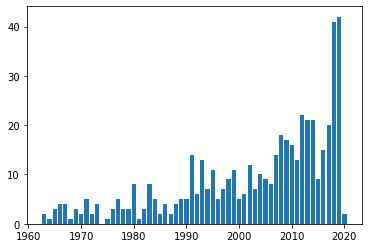

In [66]:
from matplotlib import pyplot as plt

x = new_pd.index
y = new_pd.values

x_ticks = np.arange(1950, 2030, 10)
plt.xticks(x_ticks)

y_ticks = np.arange(0, 50, 10)
plt.yticks(y_ticks)

plt.bar(x,y)

plt.show()

In [38]:
import numpy as np

y_ticks = np.arange(0, 5, 2)

In [32]:
y_ticks

array([0, 2, 4])